# 🧹 Purpose of the Script

The purpose of this script is to clean and consolidate the dataset. The goal is to have a single dataframe (persist) that has all the scores.

📚 Datasets Used

We use the following datasets:

1. **MTG zyg-1 strain**: This dataset has a confirmed suppressor for each CVL. This is collected from Dr. Maja Tarailo-Graovac's lab's high-throughput zyg-1 suppressor identification project using C. elegans as a model organism.
2. **Jolanda van Leeuwen's data**: This dataset was curated from published literatures. It has almost 500 unique suppressors but does not have any non-modifier (suppressor).
3. **OLIDA dataset**: This dataset was collected from their website. The plan is to use their data as negative samples.

🛠️ Preprocessing Steps

The preprocessing steps include:

- 🧼 Cleaning each dataset
- ➕ Adding new columns
- 🔄 Consolidating all datasets into one dataframe
- 💾 Saving the dataframe

<small>The git trace of this file can be found in `notebooks/1_add_go_similarity_score.ipynb` file. This file was created on 8 Dec 2023</small>

In [79]:
%reload_kedro

[12/09/23 04:20:24] INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=146341;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=931236;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

                    INFO     Resolved project path as: /project/6013424/rahit/modspy-data.          ]8;id=482931;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=153845;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[12/09/23 04:20:26] INFO     Kedro project ModSpy-Data                                              ]8;id=3652;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=28854;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Kedro project ModSpy-Data                                              ]8;id=954136;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=416569;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=456971;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=266105;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=530169;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=867032;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

### Import libraries

In [71]:
# -*- coding: utf-8 -*-
# from __future__ import absolute_import, division, print_function, unicode_literals
import logging
import itertools
from rich import print

import pandas as pd
import numpy as np
from modspy_data.helpers import KnowledgeGraphScores

import matplotlib.pyplot as plt
import seaborn as sns


import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, progress, performance_report
from dask_jobqueue import SLURMCluster

### Helper Functions

In [58]:
logging.getLogger().setLevel(logging.WARNING)

In [59]:
# Remove wraping quotation sign ("") from dataframe
def remove_quotes(df):
    df = df.applymap(lambda x: x.strip('"') if isinstance(x, str) else x)
    cols = [c.strip('"') for c in df.columns]
    df.rename(columns=dict(zip(df.columns, cols)), inplace=True)
    return df

In [60]:
# Add info from GO annotations to the JVL data
def match_on_annotation(row, goa, col_name='QueryGene'):
    __goa_filt = goa[goa['DB_Object_Synonym'].str.contains(row[col_name])]
    __annos = __goa_filt['GO_ID'].unique()
    row[f"{col_name}_GO"] = __annos
    return row

In [6]:
cluster = SLURMCluster(cores=1,
                       processes=1,
                       memory="8GB",
                       account="def-mtarailo_cpu",
                       walltime="00:05:00")
client = Client(cluster)
cluster

[12/08/23 02:29:18] INFO     State start                                                          ]8;id=591760;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=737204;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#1615\1615]8;;\

                    INFO       Scheduler at:   tcp://10.29.81.35:41604                            ]8;id=194204;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=685715;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3860\3860]8;;\

                    INFO       dashboard at:                     :8787                            ]8;id=669847;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=282193;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#3862\3862]8;;\

                    INFO     Receive client connection:                                           ]8;id=709713;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py\scheduler.py]8;;\:]8;id=671236;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/scheduler.py#5228\5228]8;;\
                             Client-7fad82ed-959b-11ee-8213-707990085c40                                           

                    INFO     Starting established connection to tcp://10.29.81.35:51406                 ]8;id=639834;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py\core.py]8;;\:]8;id=117150;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/distributed/core.py#867\867]8;;\

### Loading Dataset

##### 📚 Ontologies

In [101]:
# Human GO from UniPort
up_go = catalog.load('go')
up_goa = catalog.load("goa")

# Wormbase GO
wb_go = catalog.load('wb_go')
wb_goa = catalog.load("wb_goa")

# HPO
hpo = catalog.load('hpo')
hpoa = catalog.load('hpoa')

# Wormbase PO
wb_po = catalog.load('wb_po')
wb_poa = catalog.load('wb_poa')

# Alliance Genome Resource Disease Ontology
do = catalog.load('do')
doa = catalog.load('doa')

[12/09/23 04:47:38] INFO     Loading data from 'go' (KGDataSet)...                              ]8;id=790529;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=193803;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'go' (KGDataSet)...                              ]8;id=179969;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=521443;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/09/23 04:48:01] INFO     Loading data from 'goa' (GAFDataFile)...                           ]8;id=225484;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=962242;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'goa' (GAFDataFile)...                           ]8;id=927178;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=384337;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/09/23 04:48:07] INFO     Loading data from 'wb_go' (KGDataSet)...                           ]8;id=19291;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=80442;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_go' (KGDataSet)...                           ]8;id=154355;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=48445;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/09/23 04:48:32] INFO     Loading data from 'wb_goa' (GAFDataFile)...                        ]8;id=35958;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=583226;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_goa' (GAFDataFile)...                        ]8;id=18512;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=961179;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/09/23 04:48:39] INFO     Loading data from 'hpo' (KGDataSet)...                             ]8;id=717201;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=559537;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'hpo' (KGDataSet)...                             ]8;id=712340;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=996457;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /project/6013424/rahit/modspy-data/src/modspy_data/extras/datasets/kno ]8;id=604078;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=974260;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             wledge_graph_dataset.py:70: UnicodeWarning: unsound encoding, assuming                
                             utf-8 (75% confidence)                                                                
                                                                                                                   

[12/09/23 04:48:41] INFO     Loading data from 'hpoa' (CSVDataSet)...                           ]8;id=242087;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=907163;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'hpoa' (CSVDataSet)...                           ]8;id=317028;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=423760;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=537199;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=609835;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

[12/09/23 04:48:43] INFO     Loading data from 'wb_po' (KGDataSet)...                           ]8;id=993318;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=331503;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_po' (KGDataSet)...                           ]8;id=758086;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=360559;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/09/23 04:48:44] INFO     Loading data from 'wb_poa' (GAFDataFile)...                        ]8;id=545313;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=692625;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'wb_poa' (GAFDataFile)...                        ]8;id=202902;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=460563;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/09/23 04:48:47] INFO     Loading data from 'do' (KGDataSet)...                              ]8;id=249089;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=147237;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'do' (KGDataSet)...                              ]8;id=999032;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=792151;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

[12/09/23 04:48:54] INFO     Loading data from 'doa' (CSVDataSet)...                            ]8;id=433437;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=276289;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'doa' (CSVDataSet)...                            ]8;id=472755;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=350897;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=30205;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=692313;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

In [102]:
# Seperating human and worm Disease ontology annotation
human_doa = doa[doa['Taxon'].str.contains('Taxon:9606')]
worm_doa = doa[doa['Taxon'].str.contains('Taxon:6239')]

In [103]:

# Output some basic information about the graph
num_nodes = hpo.number_of_nodes()
num_edges = hpo.number_of_edges()
print(num_nodes, num_edges)



30942 41503

MTG related

In [7]:
all_files = [
    # "./data/01_raw/mtgjan_2023_all_combs_scores_2023-01-21.tsv",
     "./data/01_raw/mtg/june_2023_all_combs_scores_2023-05-31.tsv",
    ]
paired_score_df = pd.concat((pd.read_csv(f, sep='\t') for f in all_files))
print(paired_score_df.shape)
paired_score_df

(5374, 56)

,wormbase_gene_id,target_gene_id,go_n_common_ancestors_max,go_n_common_ancestors_avg,go_n_common_ancestors_bma,go_n_union_ancestors_max,go_n_union_ancestors_avg,go_n_union_ancestors_bma,go_batet_max,go_batet_avg,...,wpo_resnik_scaled_bma,wpo_lin_max,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma
0,WBGene00009065,WBGene00006988,14.0,2.310000,4.023256,132.0,31.391667,52.232558,0.368421,0.088865,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,WBGene00021171,WBGene00006988,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,WBGene00003196,WBGene00006988,7.0,1.637131,2.540000,114.0,22.180000,45.340000,1.000000,0.099218,...,0.705974,1.00000,0.334903,0.780028,1.000000,0.123475,0.491183,1.000000,0.310373,0.812368
3,WBGene00011803,WBGene00006988,10.0,2.226054,4.553571,126.0,23.554688,64.589286,1.000000,0.124857,...,0.416211,1.00000,0.414459,0.485633,1.000000,0.147428,0.213067,1.000000,0.442764,0.556453
4,WBGene00011563,WBGene00006988,16.0,3.196970,5.354167,159.0,32.956250,87.000000,1.000000,0.116295,...,0.430959,1.00000,0.343568,0.516151,1.000000,0.138143,0.291885,1.000000,0.371137,0.600209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369,WBGene00001182,WBGene00006988,8.0,2.379699,4.038462,162.0,31.414583,89.576923,0.444444,0.094707,...,0.693100,1.00000,0.239683,0.773077,1.000000,0.097038,0.419774,1.000000,0.220895,0.796617
5370,WBGene00018280,WBGene00006988,3.0,1.646259,1.851064,112.0,21.500000,39.595745,0.400000,0.091482,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5371,WBGene00018607,WBGene00006988,5.0,1.589286,2.121212,110.0,21.241667,33.325581,0.294118,0.105984,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5372,WBGene00016534,WBGene00006988,3.0,1.653846,1.947368,103.0,17.625000,24.209302,1.000000,0.220233,...,0.375910,0.79501,0.375066,0.389547,0.254411,0.108569,0.113598,0.800823,0.398932,0.412790


In [8]:
df = pd.read_csv("./data/01_raw/mtg/combined_dataset_2022-11-15-07-04.tsv", sep="\t")
df

,index,Sample,chromosome,position,ref,alt,wormbase_gene_id,gene_symbol,gene_start_position,gene_end_position,...,homology,coexpression,coexpression_transferred,experiments,experiments_transferred,database,database_transferred,textmining,textmining_transferred,combined_score
0,0,MTG93,I,13162538,G,A,WBGene00009065,F22G12.5,13162492,13182725.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,MTG93,II,3797021,T,C,WBGene00021171,Y8A9A.2,3795623,3800608.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,MTG93,II,9362312,G,A,WBGene00003196,mel-11,9358531,9369098.0,...,0.0,74.0,48.0,0.0,101.0,0.0,0.0,0.0,61.0,156.0
3,3,MTG93,III,10045380,C,T,WBGene00011803,T16G12.1,10040191,10049857.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,MTG93,III,10333748,G,A,WBGene00011563,jmjd-4,10332526,10334083.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7849,109,MTG83,X,7912032,G,A,WBGene00016534,C39D10.7,7907955,7913930.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7850,110,MTG83,X,8092257,G,A,WBGene00019493,catp-5,8089826,8098863.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7851,111,MTG83,X,9304661,G,A,WBGene00015177,tmc-2,9303724,9310439.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7852,112,MTG83,X,9435571,G,A,WBGene00006538,tbb-4,9434452,9436893.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
true_mods = pd.read_csv('./data/01_raw/mtg/confirmed_modifiers.tsv', sep="\t")
true_mods.rename(columns={"strain": "Sample", "true_modifier": "gene_symbol"}, inplace=True)

OLIDA related

In [10]:
olida_comb = catalog.load('olida_combinations').pipe(remove_quotes)
# olida_genes = catalog.load('olida_genes') # pd.read_csv('./data/01_raw/olida/Gene.tsv', sep='\t')
olida_gene_comb = catalog.load('olida_gene_combinations').pipe(remove_quotes) #pd.read_csv('./data/01_raw/olida/GeneCombination.tsv', sep='\t')

[12/08/23 23:34:03] INFO     Loading data from 'olida_combinations' (CSVDataSet)...             ]8;id=807302;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=582330;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'olida_combinations' (CSVDataSet)...             ]8;id=483048;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=387095;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=417539;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=683435;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

                    INFO     Loading data from 'olida_gene_combinations' (CSVDataSet)...        ]8;id=951397;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=975289;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'olida_gene_combinations' (CSVDataSet)...        ]8;id=512428;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=425484;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    WARNING  /home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/extras/datas ]8;id=74078;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py\warnings.py]8;;\:]8;id=766713;file:///cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/python/3.8.10/lib/python3.8/warnings.py#109\109]8;;\
                             ets/pandas/csv_dataset.py:160: ParserWarning: Falling back to the                     
                             'python' engine because the 'c' engine does not support regex                         
                             separators (separators > 1 char and different from '\s+' are                          
                             interpreted as regex); you can avoid this warning by specifying                       
                             engine='python'.                                                                      
                               return pd.read_csv(load_path, **self._load_args)                                    
                                                                                                                   

In [11]:
print(olida_comb.shape)
# print(olida_genes.shape)
print(olida_gene_comb.shape)

(1610, 22)

(1138, 7)

JVL related

In [12]:
jvl = catalog.load('jvl')
print(f"JVL shap: {jvl.shape}")

                    INFO     Loading data from 'jvl' (ExcelDataSet)...                          ]8;id=503565;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=408594;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'jvl' (ExcelDataSet)...                          ]8;id=842108;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=483381;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#492\492]8;;\

JVL shap: (932, 18)

### 🔍 Adding Ontology Annotation to each Dataset
In this step, we're conducting a thorough examination of our data sources. Our goal is to ensure standardization across all sources, which will facilitate smoother processing down the line. Standardization here means that the data is clean, consistent, and in a format that our later processes can easily handle. 

Ideally, each dataset should have at least two columns (target and modifier) containing gene symbols. These gene symbols are crucial as they serve as unique identifiers for our genetic data. Having these in each dataset ensures we can accurately cross-reference and analyze our data across multiple sources. 🧬🔬

##### 📚 Ontologies

In [119]:
# Creating mappin of genes to their associated ontology term IDs
onto_to_gene_map = {
    'human': {
        'GO': up_goa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict(),
        'PO': hpoa.groupby('gene_symbol')['hpo_id'].apply(lambda x: ','.join(x)).to_dict(),
        'DO': human_doa.groupby('DBObjectSymbol')['DOID'].apply(lambda x: ','.join(x)).to_dict(),
    },
    'celegans': {
        'GO': wb_goa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict(),
        'PO': wb_poa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict(),
        'DO': worm_doa.groupby('DBObjectSymbol')['DOID'].apply(lambda x: ','.join(x)).to_dict(),
    }
}
# human_gene_to_go_ids = up_goa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict()
# celg_gene_to_go_ids = wb_goa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict()

# human_gene_to_hpo_ids = hpoa.groupby('gene_symbol')['hpo_id'].apply(lambda x: ','.join(x)).to_dict()
# worm_gene_to_wpo_ids = wb_poa.groupby('DB_Object_Symbol')['GO_ID'].apply(lambda x: ','.join(x)).to_dict()

# worm_gene_to_doa_ids = worm_doa.groupby('DBObjectSymbol')['DOID'].apply(lambda x: ','.join(x)).to_dict()
# human_gene_to_doa_ids = human_doa.groupby('DBObjectSymbol')['DOID'].apply(lambda x: ','.join(x)).to_dict()

# print(f"Total number of unique gene symbol [Human (UniPort)] : {len(human_gene_to_go_ids.keys())}")
# print(f"Total number of unique gene symbol [Wormbase]: {len(celg_gene_to_go_ids.keys())}")

## 1️⃣ MTG

In [108]:
# Setting modifier value to int 1
true_mods['is_modifier'] = 1

In [109]:
# Merge dataframes (to use already calculated similarity values and consistency)
print(f"Old dataframe shape: {df.shape}")
paired_df = df.merge(paired_score_df, how='left', on=['wormbase_gene_id','target_gene_id'])
print(f"New dataframe shape: {paired_df.shape}")

Old dataframe shape: (7854, 102)

New dataframe shape: (7854, 156)

In [110]:
# now merging data table containing true modifiers
m_df = pd.merge(paired_df, true_mods, how='left', on=['Sample', 'gene_symbol']).drop('index', axis=1).fillna(0)
confirmed_samples = m_df[m_df['is_modifier']==True]['Sample'].unique()
m_df = m_df[m_df['Sample'].isin(confirmed_samples)]
m_df.head()

,Sample,chromosome,position,ref,alt,wormbase_gene_id,gene_symbol,gene_start_position,gene_end_position,strain,...,wpo_lin_max,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma,is_modifier
0,MTG93,I,13162538,G,A,WBGene00009065,F22G12.5,13162492,13182725.0,93,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
1,MTG93,II,3797021,T,C,WBGene00021171,Y8A9A.2,3795623,3800608.0,93,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,MTG93,II,9362312,G,A,WBGene00003196,mel-11,9358531,9369098.0,93,...,1.0,0.334903,0.780028,1.0,0.123475,0.491183,1.0,0.310373,0.812368,0.0
3,MTG93,III,10045380,C,T,WBGene00011803,T16G12.1,10040191,10049857.0,93,...,1.0,0.414459,0.485633,1.0,0.147428,0.213067,1.0,0.442764,0.556453,0.0
4,MTG93,III,10333748,G,A,WBGene00011563,jmjd-4,10332526,10334083.0,93,...,1.0,0.343568,0.516151,1.0,0.138143,0.291885,1.0,0.371137,0.600209,0.0


In [111]:
print(f"# of Samples: {len(m_df['Sample'].unique())}")
print(f"# of Unique Genes: {len(m_df['wormbase_gene_id'].unique())}")
print(f"# of Variants: {m_df.shape[0]}")
print(f"# of columns: {len(m_df.columns)}")

# of Samples: 71

# of Unique Genes: 5182

# of Variants: 7330

# of columns: 156

In [112]:
print(f"Last column: {m_df.columns[-1]}")

Last column: is_modifier

In [113]:
list(m_df.columns)

['Sample',
 'chromosome',
 'position',
 'ref',
 'alt',
 'wormbase_gene_id',
 'gene_symbol',
 'gene_start_position',
 'gene_end_position',
 'strain',
 'variant_id',
 'target_gene_id',
 'target_gene_symbol',
 'go_Resnik_max_similarity',
 'go_Resnik_BMA_similarity',
 'go_Resnik_avg_similarity',
 'go_Lin_max_similarity',
 'go_Lin_BMA_similarity',
 'go_Lin_avg_similarity',
 'go_Jiang-Conrath_max_similarity',
 'go_Jiang-Conrath_BMA_similarity',
 'go_Jiang-Conrath_avg_similarity',
 'go_SimRel_max_similarity',
 'go_SimRel_BMA_similarity',
 'go_SimRel_avg_similarity',
 'go_SimIC_max_similarity',
 'go_SimIC_BMA_similarity',
 'go_SimIC_avg_similarity',
 'go_G-SESAME_max_similarity',
 'go_G-SESAME_BMA_similarity',
 'go_G-SESAME_avg_similarity',
 'go_SimICND_max_similarity',
 'go_SimICND_BMA_similarity',
 'go_SimICND_avg_similarity',
 'go_SimICNP_max_similarity',
 'go_SimICNP_BMA_similarity',
 'go_SimICNP_avg_similarity',
 'wpo_Resnik_max_similarity',
 'wpo_Resnik_BMA_similarity',
 'wpo_Resnik_avg_

🏷️ Adding Ontology Annotation - MTG

In [135]:
def add_annotation(df: pd.DataFrame, src_trgt_cols: list, term_id_map: dict):
    # Adding a new column to df for Ontology IDs associated with each gene in source_col
    for source, target in src_trgt_cols:
        df[target] = df[source].map(term_id_map)
        df[target+'_count'] = df[target].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
    return df

In [136]:

src_trgt_cols = {
    'MTG': [
        [('target_gene_symbol', 'target_GOs'), ('gene_symbol', 'modifier_GOs')],
        [('target_gene_symbol', 'target_POs'), ('gene_symbol', 'modifier_POs')],
        [('target_gene_symbol', 'target_DOs'), ('gene_symbol', 'modifier_DOs')],
    ],
    'OLIDA': [
        [('gene_a', 'target_GOs'), ('gene_b', 'modifier_GOs')],
        [('gene_a', 'target_POs'), ('gene_b', 'modifier_POs')],
        [('gene_a', 'target_DOs'), ('gene_b', 'modifier_DOs')],
    ],
    'JVL': [
        [('QueryGene', 'target_GOs'), ('SuppressorGene', 'modifier_GOs')],
        [('QueryGene', 'target_POs'), ('SuppressorGene', 'modifier_POs')],
        [('QueryGene', 'target_DOs'), ('SuppressorGene', 'modifier_DOs')],
    ],
}

In [137]:
i = 0
for onto, map in onto_to_gene_map['celegans'].items():
    # for each type of ontologies
    # we add annotation for soure and target gene
    m_df = add_annotation(m_df, src_trgt_cols['MTG'][i], map)
    i += 1

In [23]:
# Adding a new column to pairs_df for GO IDs associated with each gene in 'gene_a'
m_df['QueryGene_go_ids'] = m_df['target_gene_symbol'].map(celg_gene_to_go_ids)
m_df['SuppressorGene_go_ids'] = m_df['gene_symbol'].map(celg_gene_to_go_ids)

m_df['QueryGene_go_id_count'] = m_df['QueryGene_go_ids'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
m_df['SuppressorGene_go_id_count'] = m_df['SuppressorGene_go_ids'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Displaying the updated pairs DataFrame
m_df[['target_gene_symbol', 'gene_symbol', 'QueryGene_go_ids', 'SuppressorGene_go_ids', 'QueryGene_go_id_count', 'SuppressorGene_go_id_count']].head()


,target_gene_symbol,gene_symbol,QueryGene_go_ids,SuppressorGene_go_ids,QueryGene_go_id_count,SuppressorGene_go_id_count
0,zyg-1,F22G12.5,"GO:0000003,GO:0000166,GO:0000278,GO:0004672,GO...","GO:0005085,GO:0005085,GO:0005085,GO:0007264",70,4
1,zyg-1,Y8A9A.2,"GO:0000003,GO:0000166,GO:0000278,GO:0004672,GO...",NaN,70,0
2,zyg-1,mel-11,"GO:0000003,GO:0000166,GO:0000278,GO:0004672,GO...","GO:0004857,GO:0005737,GO:0005737,GO:0005912,GO...",70,11
3,zyg-1,T16G12.1,"GO:0000003,GO:0000166,GO:0000278,GO:0004672,GO...","GO:0004177,GO:0005737,GO:0006508,GO:0006508,GO...",70,22
4,zyg-1,jmjd-4,"GO:0000003,GO:0000166,GO:0000278,GO:0004672,GO...","GO:0005634,GO:0005737,GO:0016706,GO:0043565,GO...",70,5


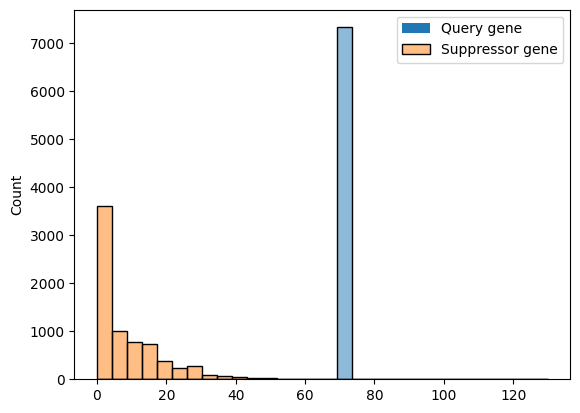

In [158]:
# Assuming df is your DataFrame and 'column' is the column you want to plot
sns.histplot(m_df[['target_GOs_count', 'modifier_GOs_count']], kde=False, bins=30)
plt.legend(labels=['Query gene', 'Suppressor gene'])
plt.show()

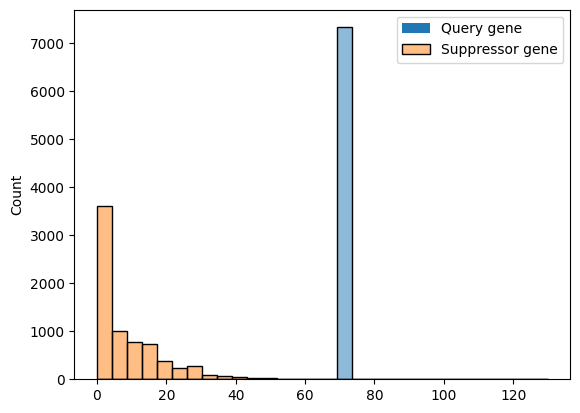

In [25]:
# Assuming df is your DataFrame and 'column' is the column you want to plot
sns.histplot(m_df[['QueryGene_go_id_count', 'SuppressorGene_go_id_count']], kde=False, bins=30)
plt.legend(labels=['Query gene', 'Suppressor gene'])
plt.show()

In [19]:
# catalog.save('mtg_cleaned', m_df)

##  2️⃣ OLIDA

In [138]:
olida_comb_filtered = olida_comb[olida_comb['Oligogenic Effect'] != 'Unknown']
print(olida_comb_filtered.shape)
print(olida_comb_filtered['Oligogenic Effect'].value_counts())

(173, 22)

Monogenic+Modifier          85
True Digenic                70
Dual Molecular Diagnosis    18
Name: Oligogenic Effect, dtype: int64

In [139]:
olida_comb_filtered.columns

Index(['OLIDA ID', 'Omim Id', 'Diseases', 'Oligogenic Effect', 'Ethnicity',
       'References', 'Associated Variants', 'FAMmanual', 'STATmanual',
       'STATknowledge', 'STATmeta', 'GENEmanual', 'GENEmanual harmonized',
       'GENEknowledge', 'GENEmeta', 'VARmanual', 'VARknowledge', 'VARmeta',
       'FUNmanual', 'FUNmeta', 'FINALmanual', 'FINALmeta'],
      dtype='object')

In [140]:
# Splitting and expanding on synonymous gene symbols
olida_gene_comb['olida_id'] = olida_gene_comb['Oligogenic variant combinations'].str.split(';')
olida_gene_comb = olida_gene_comb.explode('olida_id')

In [141]:
# Adding OLIDA combination information
_olida_m = olida_gene_comb.merge(olida_comb_filtered, how='left', left_on='olida_id', right_on='OLIDA ID')
print(_olida_m.shape)
olida_merged = _olida_m.dropna(subset=['OLIDA ID']).reindex()

(5466, 30)

In [142]:
olida_merged.shape

(195, 30)

In [143]:
print(olida_merged.shape)
print(olida_merged['Oligogenic Effect'].value_counts())

(195, 30)

Monogenic+Modifier          101
True Digenic                 76
Dual Molecular Diagnosis     18
Name: Oligogenic Effect, dtype: int64

In [144]:
# Splitting gene symbols and keeping as a list
olida_merged['gene_list'] = olida_merged['Genes'].str.split(';')
olida_merged['gene_list_len'] = olida_merged.apply(lambda row: len(row['gene_list']), axis=1)
print(olida_merged['gene_list_len'].value_counts())

2    178
3     17
Name: gene_list_len, dtype: int64

In [145]:
# Generate unique pairs from the gene list
olida_merged['gene_pairs'] = olida_merged.apply(lambda r: list(itertools.combinations(r['gene_list'], 2)), axis=1)
olida_pairs = olida_merged.explode('gene_pairs')
print(olida_pairs.shape)

(229, 33)

In [146]:
# Splitting the gene_pairs into two columns
# olida_pairs[['gene_a', 'gene_b']] = olida_pairs['gene_pairs'].map(pd.Series)
olida_pairs[['gene_a', 'gene_b']] = olida_pairs['gene_pairs'].apply(pd.Series)
olida_pairs['gene_a'] = olida_pairs['gene_a'].map(lambda x: x.strip())
olida_pairs['gene_b'] = olida_pairs['gene_b'].map(lambda x: x.strip())

print(olida_pairs['gene_a'].value_counts())
print(olida_pairs['gene_b'].value_counts())


FGFR1            18
BMP2             11
GJB2             10
COL4A4           10
CNGA3             9
                 ..
CD2AP             1
LAMA4             1
NOT_HGNC 4q35     1
EDNRB             1
ALAD              1
Name: gene_a, Length: 106, dtype: int64

SMAD6     11
PROKR2    10
CNGB3      9
COL4A5     9
GJB3       7
          ..
HNF4A      1
RP1L1      1
OGG1       1
LRP5       1
SIX1       1
Name: gene_b, Length: 114, dtype: int64

🏷️ Adding Ontology Annotation - OLIDA

In [147]:
i = 0
for onto, map in onto_to_gene_map['human'].items():
    # for each type of ontologies
    # we add annotation for soure and target gene
    olida_pairs = add_annotation(olida_pairs, src_trgt_cols['OLIDA'][i], map)
    i += 1

In [ ]:

# Adding a new column to pairs_df for GO IDs associated with each gene in 'gene_a'
olida_pairs['gene_a_go_ids'] = olida_pairs['gene_a'].map(human_gene_to_go_ids)
olida_pairs['gene_b_go_ids'] = olida_pairs['gene_b'].map(human_gene_to_go_ids)

olida_pairs['gene_a_go_id_count'] = olida_pairs['gene_a_go_ids'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
olida_pairs['gene_b_go_id_count'] = olida_pairs['gene_b_go_ids'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Displaying the updated pairs DataFrame
olida_pairs[['gene_a', 'gene_b', 'gene_a_go_ids', 'gene_a_go_id_count', 'gene_b_go_ids']].head()


,gene_a,gene_b,gene_a_go_ids,gene_a_go_id_count,gene_b_go_ids
6,ADD3,KAT2B,"GO:0005080,GO:0005200,GO:0005516,GO:0007010,GO...",19,"GO:0000977,GO:0003682,GO:0003712,GO:0003712,GO..."
8,CYP1B1,TEK,"GO:0071407,GO:0004497,GO:0004497,GO:0004497,GO...",87,"GO:0051897,GO:0070374,GO:0001725,GO:0005884,GO..."
12,GJB2,TMPRSS3,"GO:0005243,GO:0005243,GO:0005509,GO:0005515,GO...",75,"GO:0006883,GO:0004252,GO:0004252,GO:0017080,GO..."
19,RNF216,SRA1,"GO:0005515,GO:0005515,GO:0005515,GO:0005515,GO...",29,"GO:0002153,GO:0002153,GO:0006357,GO:1990904,GO..."
28,MEFV,TRAP1,"GO:0003779,GO:0005515,GO:0005515,GO:0005515,GO...",50,"GO:0003723,GO:0005164,GO:0005515,GO:0005515,GO..."


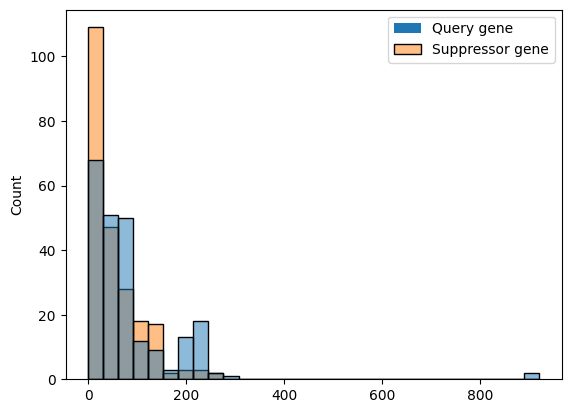

In [159]:
# Assuming df is your DataFrame and 'column' is the column you want to plot
sns.histplot(olida_pairs[['target_GOs_count', 'modifier_GOs_count']], kde=False, bins=30)
plt.legend(labels=['Query gene', 'Suppressor gene'])
plt.show()

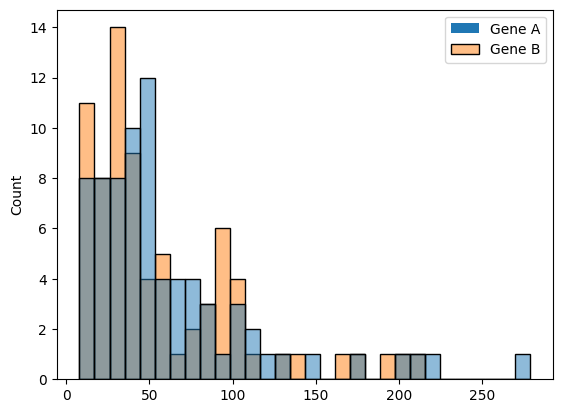

In [ ]:
# Assuming df is your DataFrame and 'column' is the column you want to plot
sns.histplot(olida_pairs[['gene_a_go_id_count','gene_b_go_id_count']], kde=False, bins=30)
plt.legend(labels=['Gene A', 'Gene B'])
plt.show()

In [35]:
catalog.save('olida_pairs', olida_pairs)

[12/08/23 23:54:16] INFO     Saving data to 'olida_pairs' (CSVDataSet)...                       ]8;id=50105;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=401257;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

                    INFO     Saving data to 'olida_pairs' (CSVDataSet)...                       ]8;id=13607;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=991624;file:///home/rahit/jupyter_py3/lib/python3.8/site-packages/kedro/io/data_catalog.py#531\531]8;;\

## 3️⃣ Jolanda van Leewen

In [148]:
jvl_pairs = jvl[['QueryGene', 'SuppressorGene']]
print(jvl_pairs['QueryGene'].value_counts())
print(jvl_pairs['SuppressorGene'].value_counts())

HBB       412
CFTR      144
SMN1       44
BRCA1      37
HTT        27
         ... 
LUC7L3      1
MFAP1       1
MITF        1
MUS81       1
XPA         1
Name: QueryGene, Length: 93, dtype: int64

HBA2       96
BCL11A     79
MYB        62
HBG2       53
SMN2       43
           ..
PRKD2       1
PPP2R2B     1
PPP2R1A     1
PLXNA1      1
MUTYH       1
Name: SuppressorGene, Length: 417, dtype: int64

🏷️ Adding Ontology Annotation - JVL

In [149]:
i = 0
for onto, map in onto_to_gene_map['human'].items():
    # for each type of ontologies
    # we add annotation for soure and target gene
    jvl = add_annotation(jvl, src_trgt_cols['JVL'][i], map)
    i += 1

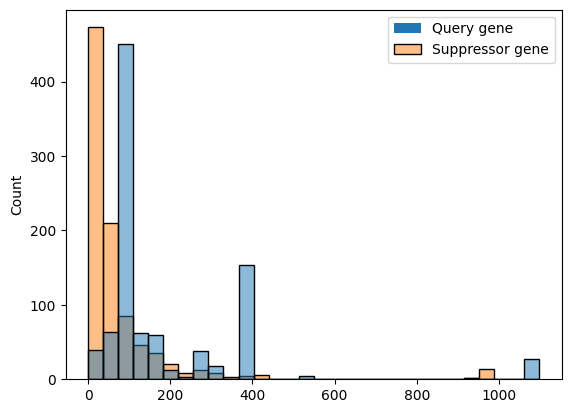

In [156]:
# Assuming df is your DataFrame and 'column' is the column you want to plot
sns.histplot(jvl[['target_GOs_count', 'modifier_GOs_count']], kde=False, bins=30)
plt.legend(labels=['Query gene', 'Suppressor gene'])
plt.show()

In [44]:
# Adding a new column to pairs_df for GO IDs associated with each gene in 'gene_a'
jvl['QueryGene_go_ids'] = jvl['QueryGene'].map(human_gene_to_go_ids)
jvl['SuppressorGene_go_ids'] = jvl['SuppressorGene'].map(human_gene_to_go_ids)

jvl['QueryGene_go_id_count'] = jvl['QueryGene_go_ids'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
jvl['SuppressorGene_go_id_count'] = jvl['SuppressorGene_go_ids'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Displaying the updated pairs DataFrame
jvl[['QueryGene', 'SuppressorGene', 'QueryGene_go_ids', 'SuppressorGene_go_ids', 'QueryGene_go_id_count', 'SuppressorGene_go_id_count']].head()


,QueryGene,SuppressorGene,QueryGene_go_ids,SuppressorGene_go_ids,QueryGene_go_id_count,SuppressorGene_go_id_count
0,APOE,CASP7,"GO:0048662,GO:0060999,GO:1902952,GO:0097113,GO...","GO:0003723,GO:0004190,GO:0004197,GO:0004197,GO...",304,92
1,APOE,HBB,"GO:0048662,GO:0060999,GO:1902952,GO:0097113,GO...","GO:0004601,GO:0031720,GO:0005344,GO:0005344,GO...",304,89
2,APOE,KL,"GO:0048662,GO:0060999,GO:1902952,GO:0097113,GO...","GO:0004566,GO:0004566,GO:0005179,GO:0005499,GO...",304,85
3,APOE,KL,"GO:0048662,GO:0060999,GO:1902952,GO:0097113,GO...","GO:0004566,GO:0004566,GO:0005179,GO:0005499,GO...",304,85
4,ATR,ETV1,"GO:0000781,GO:0003677,GO:0004672,GO:0004674,GO...","GO:0000978,GO:0000981,GO:0001228,GO:0003700,GO...",93,19


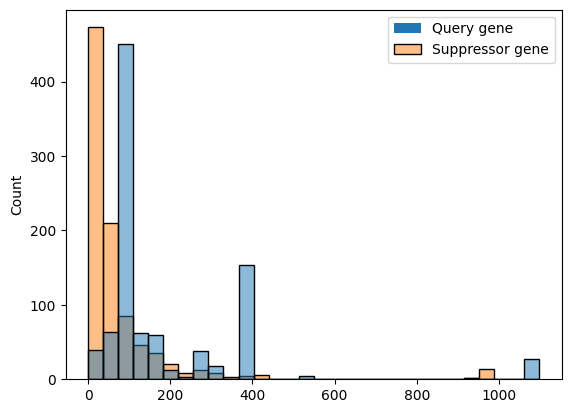

In [45]:
# Assuming df is your DataFrame and 'column' is the column you want to plot
sns.histplot(jvl[['QueryGene_go_id_count', 'SuppressorGene_go_id_count']], kde=False, bins=30)
plt.legend(labels=['Query gene', 'Suppressor gene'])
plt.show()

# Combine Datasets

Comparing OLIDA pairs with JVL

In [37]:
print(olida_pairs['Oligogenic Effect'].value_counts())

Monogenic+Modifier          66
True Digenic                47
Dual Molecular Diagnosis    28
Name: Oligogenic Effect, dtype: int64

In [38]:
# All type of pairs
jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_a')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_a')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])


jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_b')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

jvl_match = jvl.merge(olida_pairs[olida_pairs['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_b')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

QueryGene SuppressorGene gene_a  gene_b
0      CFTR          FGFR1  FGFR1  PROKR2
1      CFTR          FGFR1  FGFR1  SEMA3A
2      CFTR          FGFR1  FGFR1   GNRHR
3      KRAS          FGFR1  FGFR1  PROKR2
4      KRAS          FGFR1  FGFR1  SEMA3A
5      KRAS          FGFR1  FGFR1   GNRHR
6       HFE           BMP2   BMP2   SMAD6
7       HFE           BMP2   BMP2   SMAD6
8     PARP1          DNAH6  DNAH6   DNAI1
9       XPA          MUTYH  MUTYH    OGG1

QueryGene SuppressorGene gene_a gene_b
0       BBS4           DRD5   BBS4   BBS7
1       BBS4           DTX1   BBS4   BBS7
2       BBS4         ENGASE   BBS4   BBS7
3       BBS4          ENPP7   BBS4   BBS7
4       BBS4         ENTPD6   BBS4   BBS7
5       BBS4        LRRC74A   BBS4   BBS7
6       BBS4          PCF11   BBS4   BBS7
7       BBS4        PITPNM2   BBS4   BBS7
8       BBS4           PTMA   BBS4   BBS7
9       BBS4         RHOXF1   BBS4   BBS7
10      BBS4         TDRD12   BBS4   BBS7
11      BBS4          TEX36   BBS4   BBS7
12      BBS4          USP35   BBS4   BBS7
13      BBS4          USP38   BBS4   BBS7
14      BBS4           ZIC1   BBS4   BBS7
15     FOXC1           GJA1  FOXC1  PITX2
16     KCNH2         KCNK17  KCNH2  KCNQ1
17     KCNQ1          AKAP9  KCNQ1  SCN5A
18     KCNQ1          MTMR4  KCNQ1  SCN5A
19      MEFV           MICA   MEFV  TRAP1
20      MEFV           MICA   MEFV  TRAP1
21      MEFV           SAA1   MEFV  TRAP1
22      MITF           CDK2   MITF    TYR

QueryGene SuppressorGene    gene_a gene_b
0     BRCA2          MED25     COQ8A  MED25
1     PARP3            TTN  TRAPPC11    TTN

QueryGene SuppressorGene gene_a gene_b
0        DMD          ADRB2  ATP7B    DMD
1        DMD            FST  ATP7B    DMD
2        DMD          LTBP4  ATP7B    DMD
3        DMD          LTBP4  ATP7B    DMD
4        DMD          LTBP4  ATP7B    DMD
5        DMD          LTBP4  ATP7B    DMD
6        DMD          LTBP4  ATP7B    DMD
7        DMD          LTBP4  ATP7B    DMD
8        DMD          THBS1  ATP7B    DMD
9      FOXC1           GJA1    DPT  FOXC1
10       HFE           BMP2   HAMP    HFE
11       HFE           BMP2   HAMP    HFE
12       HFE         CYBRD1   HAMP    HFE
13       HFE         CYBRD1   HAMP    HFE
14       HFE           TFR2   HAMP    HFE
15       HFE        TMPRSS6   HAMP    HFE
16     KCNQ1          AKAP9  KCNH2  KCNQ1
17     KCNQ1          MTMR4  KCNH2  KCNQ1

In [39]:
# Considering ONLY Digenic or Dual Molecular effects FOR COMPARISON.
########################################################################################
op_filt = olida_pairs[olida_pairs['Oligogenic Effect']!='Monogenic+Modifier']
print(op_filt.shape)
######################################################################################

jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_a')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_a')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])


jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='SuppressorGene', right_on='gene_b')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

jvl_match = jvl.merge(op_filt[op_filt['gene_list_len']==2], how='inner', left_on='QueryGene', right_on='gene_b')
print(jvl_match[['QueryGene', 'SuppressorGene','gene_a', 'gene_b']])

(75, 35)

QueryGene SuppressorGene gene_a  gene_b
0      CFTR          FGFR1  FGFR1  SEMA3A
1      KRAS          FGFR1  FGFR1  SEMA3A
2       HFE           BMP2   BMP2   SMAD6
3       HFE           BMP2   BMP2   SMAD6
4     PARP1          DNAH6  DNAH6   DNAI1

QueryGene SuppressorGene gene_a gene_b
0      MEFV           MICA   MEFV  TRAP1
1      MEFV           MICA   MEFV  TRAP1
2      MEFV           SAA1   MEFV  TRAP1
3      MITF           CDK2   MITF    TYR

QueryGene SuppressorGene    gene_a gene_b
0     BRCA2          MED25     COQ8A  MED25
1     PARP3            TTN  TRAPPC11    TTN

QueryGene SuppressorGene gene_a gene_b
0        DMD          ADRB2  ATP7B    DMD
1        DMD            FST  ATP7B    DMD
2        DMD          LTBP4  ATP7B    DMD
3        DMD          LTBP4  ATP7B    DMD
4        DMD          LTBP4  ATP7B    DMD
5        DMD          LTBP4  ATP7B    DMD
6        DMD          LTBP4  ATP7B    DMD
7        DMD          LTBP4  ATP7B    DMD
8        DMD          THBS1  ATP7B    DMD
9      FOXC1           GJA1    DPT  FOXC1
10       HFE           BMP2   HAMP    HFE
11       HFE           BMP2   HAMP    HFE
12       HFE         CYBRD1   HAMP    HFE
13       HFE         CYBRD1   HAMP    HFE
14       HFE           TFR2   HAMP    HFE
15       HFE        TMPRSS6   HAMP    HFE

In [40]:
olida_pairs.columns

Index(['Entry Id', 'Genes', 'Genes Relationship', 'Protein Interactions',
       'Common Pathways', 'GENEmeta_x', 'Oligogenic variant combinations',
       'olida_id', 'OLIDA ID', 'Omim Id', 'Diseases', 'Oligogenic Effect',
       'Ethnicity', 'References', 'Associated Variants', 'FAMmanual',
       'STATmanual', 'STATknowledge', 'STATmeta', 'GENEmanual',
       'GENEmanual harmonized', 'GENEknowledge', 'GENEmeta_y', 'VARmanual',
       'VARknowledge', 'VARmeta', 'FUNmanual', 'FUNmeta', 'FINALmanual',
       'FINALmeta', 'gene_list', 'gene_list_len', 'gene_pairs', 'gene_a',
       'gene_b'],
      dtype='object')

In [41]:
# Taking ONLY Digenic or Dual Molecular effects. Because we don't know the direction of 
# effect for Monogenic+Modifier pairs
olida_pairs = olida_pairs[olida_pairs['Oligogenic Effect']!='Monogenic+Modifier']
print(olida_pairs['Oligogenic Effect'].value_counts())
print(olida_pairs.shape)

True Digenic                47
Dual Molecular Diagnosis    28
Name: Oligogenic Effect, dtype: int64

(75, 35)

In [99]:
# Adding source column
jvl['source'] = 'JVL'
olida_pairs['source'] = 'OLIDA'
m_df['source'] = 'MTG'

# Classification labels
jvl['is_modifier'] = 1
olida_pairs['is_modifier'] = 0

# Rename columns to indicate same information
jvl.rename(columns={'QueryGene': 'target_gene', 'SuppressorGene': 'modifier_gene'}, inplace=True)
olida_pairs.rename(columns={'gene_a': 'target_gene', 'gene_b': 'modifier_gene'}, inplace=True)
m_df.rename(columns={'gene_symbol': 'target_gene', 'target_gene_symbol': 'modifier_gene'}, inplace=True)


In [103]:
dataset_df = pd.concat([jvl, olida_pairs, m_df])
print(dataset_df.shape)
print(dataset_df['source'].value_counts())

(8337, 206)

MTG      7330
JVL       932
OLIDA      75
Name: source, dtype: int64

In [104]:
# Reordering important columns
desired_first_columns = ['source', 'target_gene', 'modifier_gene', 'is_modifier'] 
remaining_columns = [col for col in dataset_df.columns if col not in desired_first_columns]
new_column_order = desired_first_columns + remaining_columns
dataset_df = dataset_df[new_column_order]
dataset_df.head()


,source,target_gene,modifier_gene,is_modifier,PubmedID,Category,Tissue,QueryFunction,QueryMutation,QueryType,...,wpo_resnik_scaled_bma,wpo_lin_max,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma
0,JVL,APOE,CASP7,1.0,27358062.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/C112R,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JVL,APOE,HBB,1.0,24116184.0,Patients,-,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JVL,APOE,KL,1.0,30867273.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JVL,APOE,KL,1.0,32282020.0,Patients,Neuron,Lipid and sterol biosynthesis & transport,C112R/?,-,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JVL,ATR,ETV1,1.0,23284306.0,Cells,-,DNA replication and repair;Signaling & stress ...,silencing/silencing,LOF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
dataset_df.drop_duplicates(subset=['target_gene', 'modifier_gene'])['source'].value_counts()

MTG      5182
JVL       476
OLIDA      74
Name: source, dtype: int64

In [108]:
# TODO check gene info to retrieve gene ID for better comparison of uniqueness
dataset_df.to_csv('./data/02_intermediate/v4/05102023-combined-uncleaned-uncalc.tsv', index=False)

## Similarity (with target gene) as node feature and interaction as edge

In [77]:
src = df['wormbase_gene_id'].values
tgt = df['target_gene_id'].values
len(src)
# node_sets = [np.union1d(G[0].values, G[1].values) for G in self.graphs]
# union = reduce(np.union1d, node_sets)
# return node_sets, union

268278

Creating hashmap for the gene/nodes

In [78]:
v = np.union1d(src, tgt)
v_hashmap = dict(enumerate(v))
v_invmap = {v: k for k, v in v_hashmap.items()}
len(v_hashmap.keys())

733

In [79]:
df['vx'] = df.apply(lambda r: v_invmap[r['wormbase_gene_id']], axis=1)
df['vy'] = df.apply(lambda r: v_invmap[r['target_gene_id']], axis=1)
df.head()

,wormbase_gene_id,target_gene_id,go_n_common_ancestors_max,go_n_common_ancestors_avg,go_n_common_ancestors_bma,go_n_union_ancestors_max,go_n_union_ancestors_avg,go_n_union_ancestors_bma,go_batet_max,go_batet_avg,...,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma,vx,vy
0,WBGene00013931,WBGene00013177,2.0,2.00,2.0,19.0,11.000000,12.600000,0.500000,0.500000,...,0.120405,0.120405,0.073647,0.073647,0.073647,0.145140,0.145140,0.145140,451,420
1,WBGene00013931,WBGene00021689,2.0,2.00,2.0,89.0,46.200000,53.333333,0.133333,0.077903,...,0.136612,0.140814,0.092446,0.084209,0.086955,0.332797,0.253088,0.279658,451,668
2,WBGene00013931,WBGene00004225,0.0,0.00,0.0,18.0,10.666667,11.714286,0.000000,0.000000,...,0.349787,0.418544,0.137472,0.081294,0.089319,0.573584,0.165064,0.223424,451,137
3,WBGene00013931,WBGene00006771,2.0,1.75,1.8,32.0,12.631579,13.600000,0.333333,0.221491,...,0.221559,0.231321,0.140949,0.082794,0.083981,0.585782,0.207192,0.214919,451,208
4,WBGene00013931,WBGene00021771,2.0,2.00,2.0,45.0,26.666667,31.250000,0.333333,0.333333,...,0.120484,0.120568,0.073968,0.073698,0.073752,0.149139,0.145779,0.146451,451,669


Create Tensors for PyG object

In [80]:
vx = df['vx'].to_numpy()
vy = df['vy'].to_numpy()
e = df['go_batet_bma'].to_numpy()
print(vx, vy, e)

[451 451 451 ... 252 252 522] [420 668 137 ... 522 227 227] [0.5        0.09637953 0.        
... 0.45518207 0.39176449 0.2168107 ]

In [81]:
nodes = np.union1d(vx,vy)
n = len(nodes)

In [82]:
edge_index = torch.tensor(np.array([vx, vy]), dtype=torch.long)
edge_attr = torch.tensor(e, dtype=torch.float)
print(edge_index, edge_attr)

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]]) tensor([0.5000, 0.0964, 0.0000,  ..., 0.4552, 
0.3918, 0.2168])

In [83]:
data = Data(x=torch.zeros((n,3)), edge_index=edge_index, edge_attr=edge_attr)
print(data)

Data(x=[733, 3], edge_index=[2, 268278], edge_attr=[268278])

In [84]:
data['edge_index']

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]])

In [85]:
print("# Nodes: ", data.num_nodes)
print("# Edges: ", data.num_edges)
print("# Node Features: ", data.num_node_features)
print("Has isolated nodes? ", data.has_isolated_nodes())
print("Has self loops? ", data.has_self_loops())
print("Directed? ", data.is_directed())

# Nodes:  733

# Edges:  268278

# Node Features:  3

Has isolated nodes?  False

Has self loops?  False

Directed?  True

We do not want our model to learn label while embed. So we will do embedding in unsupervised way

In [86]:
from torch_geometric.nn import GCNConv
# from torch.utils.tensorboard import SummaryWriter
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch_geometric.nn import VGAE

In [87]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [88]:
data = train_test_split_edges(data)
data

/home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[733, 3], val_pos_edge_index=[2, 6800], val_pos_edge_attr=[6800], test_pos_edge_index=[2, 13601], test_pos_edge_attr=[13601], train_pos_edge_index=[2, 231230], train_pos_edge_attr=[231230], train_neg_adj_mask=[733, 733], val_neg_edge_index=[2, 6800], test_neg_edge_index=[2, 13601])

In [89]:
out_channels = 2
num_features = 3
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_12274/1614924763.py:1 in <module>                                          │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_12274/1614924763.py'                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'SummaryWriter' is not defined

In [90]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    # writer.add_scalar('auc train',auc,epoch) # new line
    # writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.5000, AP: 0.5000

In [70]:
pairs_df = pd.merge(protein_alias_df, pairs_df, how='left', on=['source', 'alias'])#.drop('index', axis=1).fillna(0)
pairs_df

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_24008/3608489440.py:3 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_24008/3608489440.py'                        │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:107 in merge    │
│                                                                                                  │
│    104 │   indicator: bool = False,                                                              │
│    105 │   validate: str | None = None,                                                          │
│    106 ) -> DataFrame:                                                                           │
│ ❱  107 │   op = _MergeOperation(                                                                 │
│    108 │   │   left,                                                                             │
│    109 │   │   right,                                                                            │
│    110 │   │   how=how,                                                                          │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:700 in __init__ │
│                                                                                                  │
│    697 │   │   │   self.left_join_keys,                                                          │
│    698 │   │   │   self.right_join_keys,                                                         │
│    699 │   │   │   self.join_names,                                                              │
│ ❱  700 │   │   ) = self._get_merge_keys()                                                        │
│    701 │   │                                                                                     │
│    702 │   │   # validate the merge keys dtypes. We may need to coerce                           │
│    703 │   │   # to avoid incompatible dtypes                                                    │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1097 in         │
│ _get_merge_keys                                                                                  │
│                                                                                                  │
│   1094 │   │   │   │   else:                                                                     │
│   1095 │   │   │   │   │   if not is_rkey(rk):                                                   │
│   1096 │   │   │   │   │   │   if rk is not None:                                                │
│ ❱ 1097 │   │   │   │   │   │   │   right_keys.append(right._get_label_or_level_values(rk))       │
│   1098 │   │   │   │   │   │   else:                                                             │
│   1099 │   │   │   │   │   │   │   # work-around for merge_asof(right_index=True)                │
│   1100 │   │   │   │   │   │   │   right_keys.append(right.index)                                │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/pandas/core/generic.py:1848 in               │
│ _get_label_or_level_values                                                                       │
│                                                                                                  │
│    1845 │   │   elif self._is_level_reference(key, axis=axi

In [ ]:
pint_df

In [46]:
protein_interaction_df.head()

,protein1,protein2,combined_score
0,6239.2L52.1,6239.C16C8.14,196
1,6239.2L52.1,6239.R06A4.7,375
2,6239.2L52.1,6239.B0218.3,207
3,6239.2L52.1,6239.C49F5.2,189
4,6239.2L52.1,6239.Y39B6A.13,152


In [49]:
cluster.scale(2)

In [50]:
!squeue -u $USER

            JOBID     USER              ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
          3377875    rahit     def-mtarailo_cpu    dask-worker   R       4:59     1    8        N/A      4G gra781 (None) 
          3377876    rahit     def-mtarailo_cpu    dask-worker   R       4:59     1    8        N/A      4G gra781 (None) 
          3377073    rahit     def-mtarailo_cpu    interactive   R      34:45     1    1        N/A      8G gra630 (None) 


In [37]:
!scancel -n "dask-worker"

Create protein pairs from gene pairs using STRING protein alias

In [60]:


def int_score(pair, protein_interaction_df, protein_alias_df):
    print(pair)
    return get_interaction_score(pair[0], pair[1], protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)

adj_mtx = np.array(pairs[:10])
# scores = []
# client.scatter(protein_interaction_df)
# client.scatter(protein_alias_df)
# for p in tqdm(adj_mtx):
#     score = dask.delayed(get_interaction_score)(p[0], p[1], protein_interaction_df, protein_alias_df)
#     scores.append(score)
    
# absnp.apply_along_axis(int_score, 1, adj_mtx, protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)
# adj_mtx = da.from_array(np.array(pairs[:50]), chunks=10)
# adj_mtx.compute()
adj_mtx

array([['WBGene00000022', 'WBGene00000045'],
       ['WBGene00000022', 'WBGene00000055'],
       ['WBGene00000022', 'WBGene00000057'],
       ['WBGene00000022', 'WBGene00000070'],
       ['WBGene00000022', 'WBGene00000103'],
       ['WBGene00000022', 'WBGene00000109'],
       ['WBGene00000022', 'WBGene00000135'],
       ['WBGene00000022', 'WBGene00000158'],
       ['WBGene00000022', 'WBGene00000166'],
       ['WBGene00000022', 'WBGene00000220']], dtype='<U14')

In [61]:
with TqdmCallback(desc="dasking"):
    result = da.apply_along_axis(int_score, 1, adj_mtx, protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)
    cresult = result.compute()

# time1 = time.time()
# result = result.compute()
# print('Result computed:', elapsed(time1))

['1']

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_24008/495367488.py:2 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_24008/495367488.py'                         │
│                                                                                                  │
│ /home/rahit/jupyter_py3/lib/python3.8/site-packages/dask/array/routines.py:508 in                │
│ apply_along_axis                                                                                 │
│                                                                                                  │
│    505 │   # If necessary, infer dtype and shape of the output of func1d by calling it on test   │
│    506 │   if shape is None or dtype is None:                                                    │
│    507 │   │   test_data = np.ones((1,), dtype=arr.dtype)                                        │
│ ❱  508 │   │   test_result = np.array(func1d(test_data, *args, **kwargs))                        │
│    509 │   │   if shape is None:                                                                 │
│    510 │   │   │   shape = test_result.shape                                                     │
│    511 │   │   if dtype is None:                                                                 │
│                                                                                                  │
│ /tmp/ipykernel_24008/2388726200.py:5 in int_score                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_24008/2388726200.py'                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
with TqdmCallback(desc="dasking"):
    results = dask.compute(*scores)
    # print(compute(result))
    

In [ ]:
results[:5]

In [43]:
# How many seconds since start?
def elapsed(start):
    return str(time.time() - start) + ' seconds'

In [44]:
result = da.apply_along_axis(int_score, 1, adj_mtx, protein_interaction_df=protein_interaction_df, protein_alias_df=protein_alias_df)

time1 = time.time()
result = result.compute()
print('Result computed:', elapsed(time1))

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_2043/725368228.py:1 in <module>                                            │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/725368228.py'                   │
│ /home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packa │
│ ges/dask/array/routines.py:508 in apply_along_axis                                        │
│                                                                                           │
│    505 │   # If necessary, infer dtype and shape of the output of func1d by calling it on │
│    506 │   if shape is None or dtype is None:                                             │
│    507 │   │   test_data = np.ones((1,), dtype=arr.dtype)                                 │
│ ❱  508 │   │   test_result = np.array(func1d(test_data, *args, **kwargs))                 │
│    509 │   │   if shape is None:                                                          │
│    510 │   │   │   shape = test_result.shape                                              │
│    511 │   │   if dtype is None:                                                          │
│                                                                                           │
│ /tmp/ipykernel_2043/2114408459.py:2 in int_score                                          │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/2114408459.py'                  │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 1 is out of bounds for axis 0 with size 1

In [17]:
for p in tqdm(pairs):
    score = get_interaction_score(p[0], p[1], protein_interaction_df, protein_alias_df)
    if score:
        G.add_edge(v_invmap[p[0]], v_invmap[p[1]], weight=score )

  0%|          | 0/14437251 [00:00<?, ?it/s]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_2043/2146878348.py:2 in <module>                                           │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/2146878348.py'                  │
│ /tmp/ipykernel_2043/1766830248.py:22 in get_interaction_score                             │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/1766830248.py'                  │
│                                                                                           │
│ /tmp/ipykernel_2043/1766830248.py:11 in get_string_protein_id                             │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2043/1766830248.py'                  │
│                                                                                           │
│ /home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packa │
│ ges/pandas/core/strings/accessor.py:129 in wrapper                                        │
│                                                                                           │
│    126 │   │   │   │   │   f"inferred dtype '{self._inferred_dtype}'."                    │
│    127 │   │   │   │   )                                                                  │
│    128 │   │   │   │   raise TypeError(msg)                                               │
│ ❱  129 │   │   │   return func(self, *args, **kwargs)                                     │
│    130 │   │                                                                              │
│    131 │   │   wrapper.__name__ = func_name                                               │
│    132 │   │   return cast(F, wrapper)                                                    │
│                                                                                           │
│ ╭─────────────────────────────────────── locals ────────────────────────────────────────╮ │
│ │ allowed_types = {'mixed-integer', 'mixed', 'string', 'empty'}                         │ │
│ │          args = ('^ $',)                                                              │ │
│ │          func = <function StringMethods.match at 0x2b886b0e1f70>                      │ │
│ │     func_name = 'match'                                                               │ │
│ │        kwargs = {'case': False}                                                       │ │
│ │          self = <pandas.core.strings.accessor.StringMethods object at 0x2b8957da8550> │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│ /home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packa │
│ ges/pandas/core/strings/accessor.py:1292 in match                                         │
│                                                                                           │
│   1289 │   │   │   re.match.                                                              │
│   1290 │   │   extract : Extract matched groups.                                          │
│   1291 │   │   """                                                                        │
│ ❱ 1292 │   │   result = self._data.array._str_match(pat, case=case, flags=flags, na=na)   │
│   1293 │   │   return self._wrap_result(result, fill_value=na, returns_string=False)      │
│   1294 │                                                                                  │
│   1295 │   @forbid_nonstring_types(["bytes"])     

In [ ]:
groups = df.groupby('Sample')

for g in groups:
    pairs = []
    for # check list if pair exist

## Edge list with no node features (zero valued) and GO similarity as edge weight

In [77]:
src = df['wormbase_gene_id'].values
tgt = df['target_gene_id'].values
len(src)
# node_sets = [np.union1d(G[0].values, G[1].values) for G in self.graphs]
# union = reduce(np.union1d, node_sets)
# return node_sets, union

268278

Creating hashmap for the gene/nodes

In [78]:
v = np.union1d(src, tgt)
v_hashmap = dict(enumerate(v))
v_invmap = {v: k for k, v in v_hashmap.items()}
len(v_hashmap.keys())

733

In [79]:
df['vx'] = df.apply(lambda r: v_invmap[r['wormbase_gene_id']], axis=1)
df['vy'] = df.apply(lambda r: v_invmap[r['target_gene_id']], axis=1)
df.head()

,wormbase_gene_id,target_gene_id,go_n_common_ancestors_max,go_n_common_ancestors_avg,go_n_common_ancestors_bma,go_n_union_ancestors_max,go_n_union_ancestors_avg,go_n_union_ancestors_bma,go_batet_max,go_batet_avg,...,wpo_lin_avg,wpo_lin_bma,wpo_jiang_max,wpo_jiang_avg,wpo_jiang_bma,wpo_jiang_seco_max,wpo_jiang_seco_avg,wpo_jiang_seco_bma,vx,vy
0,WBGene00013931,WBGene00013177,2.0,2.00,2.0,19.0,11.000000,12.600000,0.500000,0.500000,...,0.120405,0.120405,0.073647,0.073647,0.073647,0.145140,0.145140,0.145140,451,420
1,WBGene00013931,WBGene00021689,2.0,2.00,2.0,89.0,46.200000,53.333333,0.133333,0.077903,...,0.136612,0.140814,0.092446,0.084209,0.086955,0.332797,0.253088,0.279658,451,668
2,WBGene00013931,WBGene00004225,0.0,0.00,0.0,18.0,10.666667,11.714286,0.000000,0.000000,...,0.349787,0.418544,0.137472,0.081294,0.089319,0.573584,0.165064,0.223424,451,137
3,WBGene00013931,WBGene00006771,2.0,1.75,1.8,32.0,12.631579,13.600000,0.333333,0.221491,...,0.221559,0.231321,0.140949,0.082794,0.083981,0.585782,0.207192,0.214919,451,208
4,WBGene00013931,WBGene00021771,2.0,2.00,2.0,45.0,26.666667,31.250000,0.333333,0.333333,...,0.120484,0.120568,0.073968,0.073698,0.073752,0.149139,0.145779,0.146451,451,669


Create Tensors for PyG object

In [80]:
vx = df['vx'].to_numpy()
vy = df['vy'].to_numpy()
e = df['go_batet_bma'].to_numpy()
print(vx, vy, e)

[451 451 451 ... 252 252 522] [420 668 137 ... 522 227 227] [0.5        0.09637953 0.        
... 0.45518207 0.39176449 0.2168107 ]

In [81]:
nodes = np.union1d(vx,vy)
n = len(nodes)

In [82]:
edge_index = torch.tensor(np.array([vx, vy]), dtype=torch.long)
edge_attr = torch.tensor(e, dtype=torch.float)
print(edge_index, edge_attr)

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]]) tensor([0.5000, 0.0964, 0.0000,  ..., 0.4552, 
0.3918, 0.2168])

In [83]:
data = Data(x=torch.zeros((n,3)), edge_index=edge_index, edge_attr=edge_attr)
print(data)

Data(x=[733, 3], edge_index=[2, 268278], edge_attr=[268278])

In [84]:
data['edge_index']

tensor([[451, 451, 451,  ..., 252, 252, 522],
        [420, 668, 137,  ..., 522, 227, 227]])

In [85]:
print("# Nodes: ", data.num_nodes)
print("# Edges: ", data.num_edges)
print("# Node Features: ", data.num_node_features)
print("Has isolated nodes? ", data.has_isolated_nodes())
print("Has self loops? ", data.has_self_loops())
print("Directed? ", data.is_directed())

# Nodes:  733

# Edges:  268278

# Node Features:  3

Has isolated nodes?  False

Has self loops?  False

Directed?  True

We do not want our model to learn label while embed. So we will do embedding in unsupervised way

In [86]:
from torch_geometric.nn import GCNConv
# from torch.utils.tensorboard import SummaryWriter
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch_geometric.nn import VGAE

In [87]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [88]:
data = train_test_split_edges(data)
data

/home/rahit/.cache/pypoetry/virtualenvs/gemo-data-DHiuQg47-py3.8/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[733, 3], val_pos_edge_index=[2, 6800], val_pos_edge_attr=[6800], test_pos_edge_index=[2, 13601], test_pos_edge_attr=[13601], train_pos_edge_index=[2, 231230], train_pos_edge_attr=[231230], train_neg_adj_mask=[733, 733], val_neg_edge_index=[2, 6800], test_neg_edge_index=[2, 13601])

In [89]:
out_channels = 2
num_features = 3
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_12274/1614924763.py:1 in <module>                                          │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_12274/1614924763.py'                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'SummaryWriter' is not defined

In [90]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    # writer.add_scalar('auc train',auc,epoch) # new line
    # writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.5000, AP: 0.5000

In [40]:

cluster.close()
client.close()